In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy import stats
import warnings
import sys
import seaborn as sns
sys.path.append('../')
pd.options.mode.chained_assignment = None 



In [2]:
vdf = pd.read_csv("beeActivity.csv")
#vdf = vdf.drop_duplicates(subset=['track_starttime','track_tagid'], keep='last')

In [3]:
break_indexes = vdf.separate_event[vdf.separate_event == True].index.tolist()
break_indexes.append(len(vdf)-1)

In [4]:
#SECONDS THRESHOLD
#used to classify multiple detections into part of a single event
#also used to tell when two detections are part of different events
#by checking the time distance between them
t = 15

#DISTANCE THRESHOLD
#used to classify an event as entering or exiting
#when two consecutive detections of the same event 
#have this distance in y position, they are utilized to predict
#the trajectory. If not then it checks the detection prior for
#the distance threshold, and continues doing so until it finds
#the last detection in the event or until it finds a distance
#of more than the threshold

t2 = 150

#ANGLE THRESHOLD
#used to generate angle ranges for classifying as exiting
#or entering

angle = 10

In [5]:
vdf['event_id'] = np.nan
first_detection = 0
for i in range(len(break_indexes)):
        
        vdf['event_id'].iloc[first_detection:break_indexes[i]+1] = i
        first_detection = break_indexes[i]+1

## RULES

In [6]:
#RULE 1 - INSIDE-OUTSIDE OR OUTSIDE-INSIDE
def in_out(data):
    if data['track_shape'].iloc[-1] == "inside_outside" or data['track_shape'].iloc[-1] == "ramp_outside":
        return "exiting"
    elif data['track_shape'].iloc[-1] == "outside_inside" or data['track_shape'].iloc[-1] == "outside_ramp":
        return "entering"
    else:
        return "unknown"
        

#RULE 2 ITERATE BACKWARDS DISPLACEMENT
def displacement(data):            
        coordinates = data['cy']

        #assign final position to final variable
        final = coordinates.iloc[-1]

        #iterate backwards until distance threshold is surpassed
        for k in range(len(coordinates)):
            prev = coordinates.iloc[len(coordinates)-k-1]
            dif = final - prev
            if abs(dif) >= t2:
                if dif < 0:
                    return 'exiting'
                elif dif > 0:
                    return 'entering'
                else:
                    return 'unknown'
                break
            #if distance is never surpassed, reach the very first index
            elif k == len(coordinates) - 1:
                if dif < 0:
                    return 'exiting'
                elif dif > 0:
                    return 'entering'
                else:
                    return 'unknown'
            

#RULE 3 SUMMED DIRECTIONAL ANGLE

def angles(data):
    exit_min = 180 + angle
    exit_max = 360 - angle
    enter_min = angle
    enter_max = 180 - angle

    #obtain all angles of event
    coordinates = data['angle'].to_numpy()

    #obtain vector angle
    unit_dx = np.cos(np.deg2rad(coordinates))
    unit_dy = np.sin(np.deg2rad(coordinates))
    avg_x = np.average(unit_dx)
    avg_y = np.average(unit_dy)
    if avg_x == 0 and avg_y == 0:
        deg = 0
    elif avg_x == 0 and avg_y != 0:
        if avg_y > 0:
            deg = 270
        elif avg_y < 0:
            deg = 90
    else:
        # determine direction angle using arctan
        deg = np.rad2deg(np.arctan(avg_y/avg_x))
                    
        # since arctan limits are (-90,90), use coordinate directions to 
        # correct the angle to be within standard [0,360) range
        if avg_x > 0 and avg_y >= 0:
            deg = deg
        elif avg_x < 0 and avg_y >= 0:
            deg = 180 + deg
        elif avg_x < 0 and avg_y < 0:
            deg = deg + 180
        elif avg_x > 0 and avg_y < 0:
            deg = 360 + deg

    if deg >= exit_min and deg <= exit_max:
        return 'exiting'
    elif deg >= enter_min and deg <= enter_max:
        return 'entering'
    else:
        return 'unknown'

#subfunction of previous application, except with one
#single angle instead

def getangle(coordinates):
    exit_min = 180 + angle
    exit_max = 360 - angle
    enter_min = angle
    enter_max = 180 - angle

    avg_x = np.cos(np.deg2rad(coordinates))
    avg_y = np.sin(np.deg2rad(coordinates))
    if avg_x == 0 and avg_y == 0:
        deg = 0
    elif avg_x == 0 and avg_y != 0:
        if avg_y > 0:
            deg = 270
        elif avg_y < 0:
            deg = 90
    else:
        # determine direction angle using arctan
        deg = np.rad2deg(np.arctan(avg_y/avg_x))
                    
        # since arctan limits are (-90,90), use coordinate directions to 
        # correct the angle to be within standard [0,360) range
        if avg_x > 0 and avg_y >= 0:
            deg = deg
        elif avg_x < 0 and avg_y >= 0:
            deg = 180 + deg
        elif avg_x < 0 and avg_y < 0:
            deg = deg + 180
        elif avg_x > 0 and avg_y < 0:
            deg = 360 + deg

    if deg >= exit_min and deg <= exit_max:
        return 'exiting'
    elif deg >= enter_min and deg <= enter_max:
        return 'entering'
    else:
        return 'unknown'

#RULE 4 LAST DIRECTIONAL ANGLE

def lastangle(data):
   
    coordinates = data['angle'].iloc[-1]

    return getangle(coordinates)


#RULE 5 INIT - FINAL DISPLACEMENT
def displacementinit(data):            
        coordinates = data['cy']
        
        final = coordinates.iloc[-1]
        init = coordinates.iloc[0]

        if init > final:
            return 'exiting'
        elif final > init:
            return 'entering'
        else:
            return 'unknown'             

#RULE 6 FIRST DIRECTIONAL ANGLE

def firstangle(data):
   
    coordinates = data['angle'].iloc[0]

    return getangle(coordinates)


#RULE 7 ITERATE FORWARDS DISPLACEMENT
def displacement2(data):            
        coordinates = data['cy']

        #set first variable to first position in event
        first = coordinates.iloc[0]

        #iterate forward until distance threshold is surpassed
        for k in range(1,len(coordinates)):
            next = coordinates.iloc[k]
            dif = first - next
            if abs(dif) >= t2:
                if dif > 0:
                    return 'exiting'
                elif dif < 0:
                    return 'entering'
                else:
                    return 'unknown'
                break
            #if never surpassed, compare with very last detection
            elif k == len(coordinates) - 1:
                if dif > 0:
                    return 'exiting'
                elif dif < 0:
                    return 'entering'
                else:
                    return 'unknown'
            


####CLASSIFICATION AS ENTERING-EXITING OR EXITING-ENTERING

#RULE 1 ITERATE BACKWARDS AND FORWARDS DISPLACEMENT
#COMBINES FORWARD ITERATION AND BACKWARDS ITERATION
def displacementbackforth(data):   

        coordinates = data['cy']

        #ending movement
        final = coordinates.iloc[-1]
        
        for k in range(len(coordinates)):
            prev = coordinates.iloc[len(coordinates)-k-1]
            dif = final - prev
            if abs(dif) >= t2:
                if dif < 0:
                    string2 = 'exiting'
                elif dif > 0:
                    string2 = 'entering'
                else:
                    string2 = 'unknown'
                break
            elif k == len(coordinates) - 1:
                if dif < 0:
                    string2 = 'exiting'
                elif dif > 0:
                    string2 = 'entering'
                else:
                    string2 = 'unknown'

        #beginning movement
        #iterate forwards
        first = coordinates.iloc[0]
        
        for k in range(1,len(coordinates)):
            next = coordinates.iloc[k]
            dif = first - next
            if abs(dif) >= t2:
                if dif > 0:
                    string = 'exiting'
                elif dif < 0:
                    string = 'entering'
                else:
                    string = 'unknown'
                break
            elif k == len(coordinates) - 1:
                if dif > 0:
                    string = 'exiting'
                elif dif < 0:
                    string = 'entering'
                else:
                    string = 'unknown'

        #if both directions are the same, return value
        #else return compound event
        return string if string == string2 else f"{string}-{string2}"
        

#RULE 2 FIRST AND LAST DIRECTIONAL ANGLE
#COMBINES FIRST ANGLE AND LAST ANGLE

def lastfirstangle(data):

    coordinates = data['angle'].iloc[-1]

    string2 = getangle(coordinates)

    coordinates = data['angle'].iloc[0]

    string = getangle(coordinates)

    #if both directions are the same, return value
    #else return compound event
    return string if string == string2 else f"{string}-{string2}"


#RULE 3 THRESHOLD BIDIRECTIONAL
def in_out2(data):
    if data['track_shape'].iloc[-1] == "inside_outside" or data['track_shape'].iloc[-1] == "ramp_outside":
        return "exiting"
    elif data['track_shape'].iloc[-1] == "outside_inside" or data['track_shape'].iloc[-1] == "outside_ramp":
        return "entering"
    elif data['track_shape'].iloc[-1] == "outside_outside":
        return "entering-exiting"
    elif data['track_shape'].iloc[-1] == "inside_inside":
        return "exiting-entering"
    else:
        return "unknown"
        

In [9]:
#read cheatsheet of all cases

cheatsheet = pd.read_csv("cheatsheet.csv")

## ACCURACY 

Accuracy tested on regular simple cases

In [10]:
#compare classifications against ground truth

removed = ['entering-exiting','exiting-entering','unknown']

cheatsheet1 = cheatsheet[~cheatsheet.event.isin(removed)]

entering_count = len(cheatsheet[cheatsheet['event'] == 'entering'])
exiting_count = len(cheatsheet[cheatsheet['event'] == 'exiting'])
individual_counts = {}

functions = {
    'THRS_DOUBLE': in_out,
    'THRS_BIDIRECTIONAL':in_out2,
    'DISP_START_END': displacementinit,
    'DISP_START': displacement2,
    'DISP_END': displacement,
    'DISP_BIDIRECTIONAL':displacementbackforth,
    'BEE_ANGLE_SUM': angles,
    'BEE_ANGLE_START': firstangle,
    'BEE_ANGLE_END': lastangle,
    'BEE_ANGLE_BIDIRECTIONAL':lastfirstangle
}

compound = {'DISP_BIDIRECTIONAL':0,'BEE_ANGLE_BIDIRECTIONAL':0,'THRS_BIDIRECTIONAL':0}

for rule, func in functions.items():
    individual_counts[rule] = {'entering':0,'exiting':0}

accuracy = {r: 0 for r in functions}

for index, row in cheatsheet1.iterrows():
    event = row['event']
    line = row['eventid']
    detections = vdf[vdf['event_id'] == line]

    for rule, func in functions.items():
        if func(detections) == event:
            accuracy[rule] += 1
            individual_counts[rule][event] += 1
        if func(detections) == "entering-exiting" or func(detections) == "exiting-entering":
            compound[rule] += 1
        



In [11]:
results = {k: v/len(cheatsheet1) for k, v in accuracy.items()}
results

{'THRS_DOUBLE': 0.9111969111969112,
 'THRS_BIDIRECTIONAL': 0.9111969111969112,
 'DISP_START_END': 0.9884169884169884,
 'DISP_START': 0.9806949806949807,
 'DISP_END': 0.9768339768339769,
 'DISP_BIDIRECTIONAL': 0.9652509652509652,
 'BEE_ANGLE_SUM': 0.9575289575289575,
 'BEE_ANGLE_START': 0.8803088803088803,
 'BEE_ANGLE_END': 0.861003861003861,
 'BEE_ANGLE_BIDIRECTIONAL': 0.752895752895753}

C:\Users\kashi\AppData\Local\Temp\ipykernel_11032\88023551.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.set_xticklabels(plt.get_xticklabels(), rotation=90)


[Text(0, 0, 'THRS_DOUBLE'),
 Text(1, 0, 'THRS_BIDIRECTIONAL'),
 Text(2, 0, 'DISP_START_END'),
 Text(3, 0, 'DISP_START'),
 Text(4, 0, 'DISP_END'),
 Text(5, 0, 'DISP_BIDIRECTIONAL'),
 Text(6, 0, 'BEE_ANGLE_SUM'),
 Text(7, 0, 'BEE_ANGLE_START'),
 Text(8, 0, 'BEE_ANGLE_END'),
 Text(9, 0, 'BEE_ANGLE_BIDIRECTIONAL')]

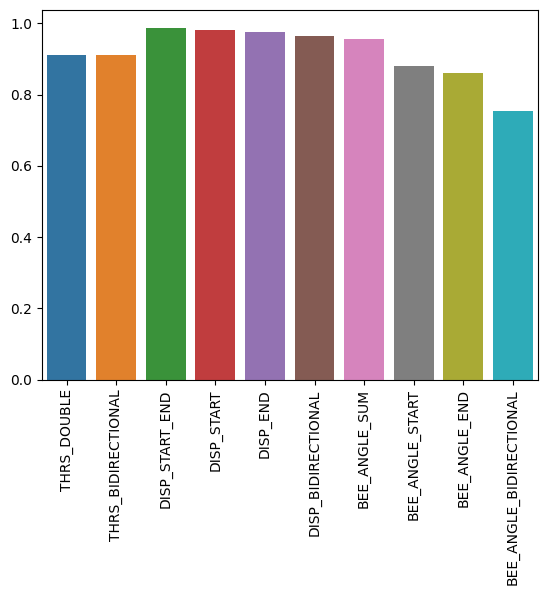

In [12]:
keys = list(accuracy.keys())
vals = [float(accuracy[k])/len(cheatsheet1) for k in keys]
plt = sns.barplot(x=keys, y=vals, hue=keys)
plt.set_xticklabels(plt.get_xticklabels(), rotation=90)

In [13]:
individual_counts

{'THRS_DOUBLE': {'entering': 79, 'exiting': 157},
 'THRS_BIDIRECTIONAL': {'entering': 79, 'exiting': 157},
 'DISP_START_END': {'entering': 87, 'exiting': 169},
 'DISP_START': {'entering': 86, 'exiting': 168},
 'DISP_END': {'entering': 88, 'exiting': 165},
 'DISP_BIDIRECTIONAL': {'entering': 86, 'exiting': 164},
 'BEE_ANGLE_SUM': {'entering': 81, 'exiting': 167},
 'BEE_ANGLE_START': {'entering': 62, 'exiting': 166},
 'BEE_ANGLE_END': {'entering': 86, 'exiting': 137},
 'BEE_ANGLE_BIDIRECTIONAL': {'entering': 61, 'exiting': 134}}

In [14]:
df = pd.DataFrame.from_dict(individual_counts).transpose().reset_index()
df['entering'] = df['entering']/entering_count
df['exiting'] = df['exiting']/exiting_count
df = pd.melt(df, id_vars=['index'], value_vars=['entering','exiting'])
df = df.rename(columns={"index": "algorithm", "variable": "event", "value": "accuracy"})


C:\Users\kashi\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\kashi\AppData\Local\Temp\ipykernel_11032\1642391400.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
C:\Users\kashi\AppData\Local\Temp\ipykernel_11032\1642391400.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


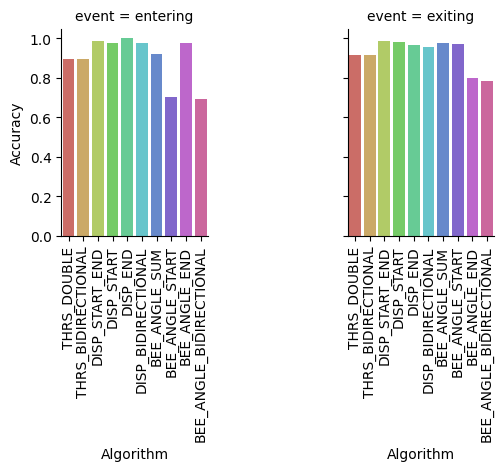

In [21]:
#sns.color_palette("hls", 8)
plt = sns.FacetGrid(df, col="event", hue="algorithm",palette="hls")
plt.map(sns.barplot,'algorithm','accuracy')

for ax in plt.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.set_axis_labels(x_var="Algorithm", y_var="Accuracy")


plt.savefig("accuracy1.png",bbox_inches='tight') 

AMOUNT OF CASES CLASSIFIED AS COMPOUND DESPITE BEING SIMPLE

In [23]:
compound

{'DISP_BIDIRECTIONAL': 7,
 'BEE_ANGLE_BIDIRECTIONAL': 25,
 'THRS_BIDIRECTIONAL': 19}

Accuracy for compound cases

In [24]:
#cheatsheet of compound events
#compare classifications against ground truth
filter = ['entering-exiting','exiting-entering']

cheatsheet2 = cheatsheet[cheatsheet.event.isin(filter)]
enter_exit_count = len(cheatsheet[cheatsheet['event'] == 'entering-exiting'])
exit_enter_count = len(cheatsheet[cheatsheet['event'] == 'exiting-entering'])
individual_counts = {}

functions = {
    'DISP_BIDIRECTIONAL': displacementbackforth,
    'BEE_ANGLE_BIDIRECTIONAL': lastfirstangle,
    'THRS_BIDIRECTIONAL':in_out2
}

accuracy = {r: 0 for r in functions}
for rule, func in functions.items():
    individual_counts[rule] = {'entering-exiting':0,'exiting-entering':0}


for index, row in cheatsheet2.iterrows():
    event = row['event']
    line = row['eventid']
    detections = vdf[vdf['event_id'] == line]

    for rule, func in functions.items():
        if func(detections) == event:
            individual_counts[rule][event] += 1
            accuracy[rule] += 1



In [25]:
results = {k: v/len(cheatsheet2) for k, v in accuracy.items()}
results

{'DISP_BIDIRECTIONAL': 0.9,
 'BEE_ANGLE_BIDIRECTIONAL': 0.6230769230769231,
 'THRS_BIDIRECTIONAL': 0.8538461538461538}

In [26]:
df = pd.DataFrame.from_dict(individual_counts).transpose().reset_index()
df['entering-exiting'] = df['entering-exiting']/enter_exit_count
df['exiting-entering'] = df['exiting-entering']/exit_enter_count
df = pd.melt(df, id_vars=['index'], value_vars=['entering-exiting','exiting-entering'])
df = df.rename(columns={"index": "algorithm", "variable": "event", "value": "accuracy"})


C:\Users\kashi\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\kashi\AppData\Local\Temp\ipykernel_11032\2427428900.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
C:\Users\kashi\AppData\Local\Temp\ipykernel_11032\2427428900.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


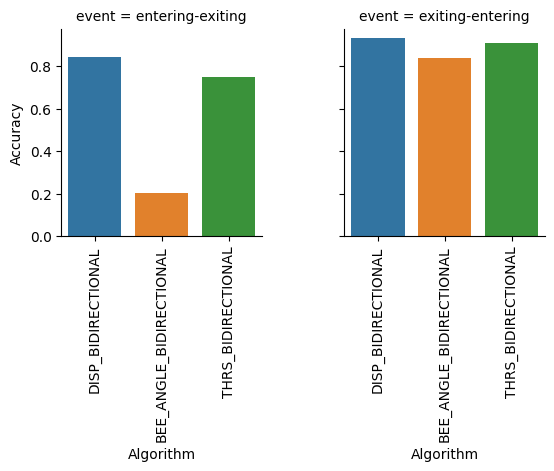

In [27]:
plt = sns.FacetGrid(df, col="event", hue="algorithm")
plt.map(sns.barplot,'algorithm','accuracy')

for ax in plt.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.set_axis_labels(x_var="Algorithm", y_var="Accuracy")

plt.savefig("accuracy2.png",bbox_inches='tight') 

## DIVERGENCE SCORE

Tested on regular simple cases

In [36]:
rule_names = ['THRS_DOUBLE', 'THRS_BIDIRECTIONAL', 'DISP_START_END', 'DISP_START','DISP_END','DISP_BIDIRECTIONAL', 'BEE_ANGLE_SUM',
              'BEE_ANGLE_START','BEE_ANGLE_END','BEE_ANGLE_BIDIRECTIONAL']
complement = {rule: {rr: 0 for rr in rule_names} for rule in rule_names}
for index, row in cheatsheet1.iterrows():
    event = row['event']
    line = row['eventid']
    detections = vdf[vdf['event_id'] == line]
    #rules
    rules = {
    'THRS_DOUBLE': in_out(detections),
    'THRS_BIDIRECTIONAL':in_out2(detections),
    'DISP_START_END': displacementinit(detections),
    'DISP_START': displacement2(detections),
    'DISP_END': displacement(detections),
    'DISP_BIDIRECTIONAL':displacementbackforth(detections),
    'BEE_ANGLE_SUM': angles(detections),
    'BEE_ANGLE_START': firstangle(detections),
    'BEE_ANGLE_END': lastangle(detections),
    'BEE_ANGLE_BIDIRECTIONAL':lastfirstangle(detections)
    }

    for key, value in rules.items():
        for otherrule, othervalue in rules.items():
            #compare if rule's classification is different from previous rule
            if otherrule != key and othervalue != value:
                complement[key][otherrule] += 1
   


In [37]:
#X axis -> Y axis
df = pd.DataFrame.from_dict(complement).transpose()/len(cheatsheet1)
df

,THRS_DOUBLE,THRS_BIDIRECTIONAL,DISP_START_END,DISP_START,DISP_END,DISP_BIDIRECTIONAL,BEE_ANGLE_SUM,BEE_ANGLE_START,BEE_ANGLE_END,BEE_ANGLE_BIDIRECTIONAL
THRS_DOUBLE,0.000000,0.073359,0.081081,0.081081,0.092664,0.092664,0.092664,0.166023,0.185328,0.277992
THRS_BIDIRECTIONAL,0.073359,0.000000,0.081081,0.081081,0.092664,0.081081,0.096525,0.169884,0.189189,0.266409
DISP_START_END,0.081081,0.081081,0.000000,0.007722,0.019305,0.027027,0.030888,0.108108,0.127413,0.235521
DISP_START,0.081081,0.081081,0.007722,0.000000,0.027027,0.027027,0.030888,0.100386,0.135135,0.235521
DISP_END,0.092664,0.092664,0.019305,0.027027,0.000000,0.027027,0.050193,0.127413,0.135135,0.247104
DISP_BIDIRECTIONAL,0.092664,0.081081,0.027027,0.027027,0.027027,0.000000,0.054054,0.127413,0.146718,0.235521
BEE_ANGLE_SUM,0.092664,0.096525,0.030888,0.030888,0.050193,0.054054,0.000000,0.123552,0.150579,0.250965
BEE_ANGLE_START,0.166023,0.169884,0.108108,0.100386,0.127413,0.127413,0.123552,0.000000,0.235521,0.235521
BEE_ANGLE_END,0.185328,0.189189,0.127413,0.135135,0.135135,0.146718,0.150579,0.235521,0.000000,0.235521
BEE_ANGLE_BIDIRECTIONAL,0.277992,0.266409,0.235521,0.235521,0.247104,0.235521,0.250965,0.235521,0.235521,0.000000


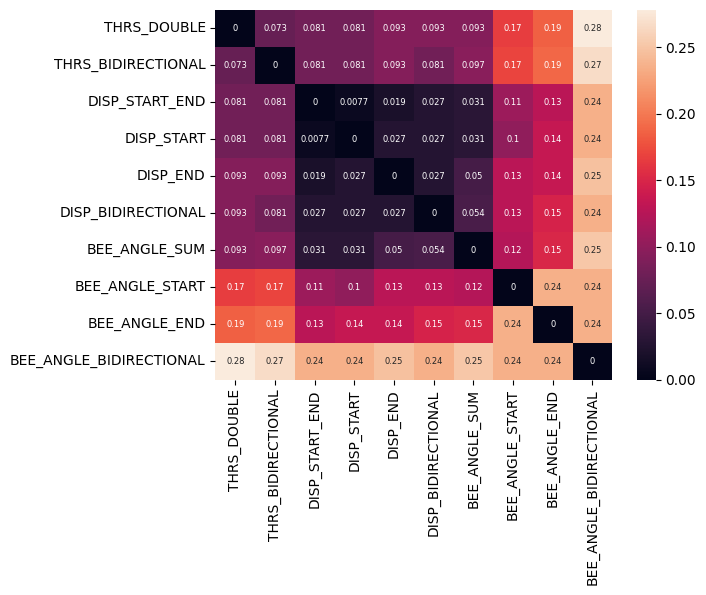

In [39]:
plot = sns.heatmap(df, annot=True,annot_kws={"size": 6})
fig = plot.get_figure()
fig.savefig("divergencescore1.png",bbox_inches='tight') 

Cheatsheet with compound cases

In [31]:
rule_names = ['DISP_BIDIRECTIONAL','BEE_ANGLE_BIDIRECTIONAL', 'THRS_BIDIRECTIONAL']
complement = {rule: {rr: 0 for rr in rule_names} for rule in rule_names}
for index, row in cheatsheet2.iterrows():
    event = row['event']
    line = row['eventid']
    detections = vdf[vdf['event_id'] == line]
    #rules
    rules = {
    'DISP_BIDIRECTIONAL':displacementbackforth(detections),
    'BEE_ANGLE_BIDIRECTIONAL':lastfirstangle(detections),
    'THRS_BIDIRECTIONAL':in_out2(detections)
    }

    for key, value in rules.items():
        for otherrule, othervalue in rules.items():
            if otherrule != key and othervalue != value:
                complement[key][otherrule] += 1
   


In [32]:
df = pd.DataFrame.from_dict(complement).transpose()/len(cheatsheet2)
df

,DISP_BIDIRECTIONAL,BEE_ANGLE_BIDIRECTIONAL,THRS_BIDIRECTIONAL
DISP_BIDIRECTIONAL,0.000000,0.361538,0.207692
BEE_ANGLE_BIDIRECTIONAL,0.361538,0.000000,0.415385
THRS_BIDIRECTIONAL,0.207692,0.415385,0.000000


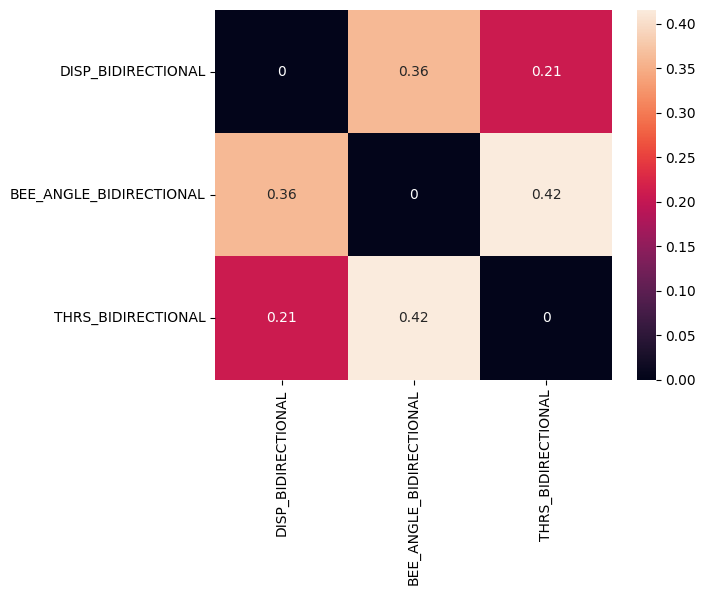

In [33]:
plot = sns.heatmap(df, annot=True)
fig = plot.get_figure()
fig.savefig("divergencescore2.png",bbox_inches='tight') 